# <center>Прогноз среднгей стоимости клика в рекламной сети Яндекс.Директ</center>
<center> Автор: Польников Эдуард


In [228]:
%matplotlib inline


from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%pylab inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.learning_curve import learning_curve
from scipy import stats
from scipy.sparse import csr_matrix, coo_matrix, hstack

from sklearn.feature_extraction.text import TfidfVectorizer


Populating the interactive namespace from numpy and matplotlib


In [229]:
df=pd.read_csv('ya_click.csv')
df.head(5)

,Дата,Кампания,№ Кампании,№ Объявления,Тип объявления,Условие показа,Тип условия показа,Тип площадки,Внешние сети,Регион таргетинга,Позиция,Тип устройства,Показы,Клики,Расход (руб.),Ср. цена клика (руб.)
0,01.03.2018,08.Забытое_в_корзине_СЕТЬ,32304512,M-5230636924,Текстово-графическое объявление,Забытое в корзине,условие подбора аудитории,сети,Яндекс и РСЯ,Балашиха,прочее,десктоп,1,0,0,-
1,01.03.2018,08.Забытое_в_корзине_СЕТЬ,32304512,M-5230636924,Текстово-графическое объявление,Забытое в корзине,условие подбора аудитории,сети,Яндекс и РСЯ,Белгородская область (более точно регион не оп...,прочее,десктоп,1,0,0,-
2,01.03.2018,08.Забытое_в_корзине_СЕТЬ,32304512,M-5230636924,Текстово-графическое объявление,Забытое в корзине,условие подбора аудитории,сети,Яндекс и РСЯ,Братск,прочее,десктоп,4,0,0,-
3,01.03.2018,08.Забытое_в_корзине_СЕТЬ,32304512,M-5230636924,Текстово-графическое объявление,Забытое в корзине,условие подбора аудитории,сети,Яндекс и РСЯ,Брянск,прочее,десктоп,2,0,0,-
4,01.03.2018,08.Забытое_в_корзине_СЕТЬ,32304512,M-5230636924,Текстово-графическое объявление,Забытое в корзине,условие подбора аудитории,сети,Яндекс и РСЯ,Владивосток,прочее,десктоп,24,0,0,-


# Часть 1. Описание набора данных и признаков

Задача взята с реального проекта. Заказчику требуется по показателям рекламы в Яндекс.Директа предсказывать 
среднюю цену клика. Данные брались из личного кабинета заказчика, была сделана выгрузка за определенный период.
Ценность задачи для заказчика в том, что он хочет с помощью прогноза оптимальнее управлять ставками в объявлениях.
Настроить этот процесс усправления ставками автоматически. Не смотря на то, что на рынке есть уже готовые решения для этого, заказчик хочет сделать свое инливидуальное решение.

**Дата** - дата рекламной кампании содержит число, месяц, год

**Кампания** - название рекламной кампании

**№ Кампании** - номер рекламной кампании в Яндекс.Директ

**№ Объявления** - номер объявления в рекламной системе Яндекс.Директ

**Тип объявления** - тип объявления в рекламной системе Яндекс.Директ(бывает текстово-графическим, те содержит текст и картинку, бывает просто графическим, те содержит только одну картинку) 

**Условие показа** - условия показа рекламного объявления Яндекс.Директ (это условие может создаться самим владельцем сайта, например: брошенные корзины - это условие берется из Яндекс.Метрики. Либо содержит ключевое слово, по которому показываются объявление, например: "подарки на 8 марта"

**Тип условия показа** - показывает был ли параметр "условие показа" выше придуман владельцем сайта, те взять из Яндекс.Метрики или объявление показывалось по ключевому слову (типы: "условие подбора аудитории" - придумано владельцем сайта, "фраза" - показ по ключевому слову) .

***Тип площадки*** - на какой площадке ( рекламной сети Яндекс или на поиске ) было показано объявление.

***Внешние сети*** - на каких площадках(сайтах) было показано объявление. В нашем датасете это Яндекс.Сети и Яндекс.Поиск, но в расширенном могут быть и другие сайты.

***Регион таргетинга*** - в каком регионе/городе показывалось объявление.  

***Позиция***  - где размещалось объвления, бывает VIP размещение, называемое "спецразмещением" и "прочее", те объявление показывается на плохо видимых местах.

***Тип устройства*** - на каком типе устройства показывалось объявление (десктоп, планшет, мобаил)

***Показы*** - количество показов объявления

***Клики*** - количество кликов по объявлению

***Расход (руб.)*** - расходны затраченные на объявление

***Ср. цена клика (руб.)*** - средняя цена клика по объявлению (пронозируемая пременная)

In [230]:
df.columns

Index(['Дата', 'Кампания', '№ Кампании', '№ Объявления', 'Тип объявления',
       'Условие показа', 'Тип условия показа', 'Тип площадки', 'Внешние сети',
       'Регион таргетинга', 'Позиция', 'Тип устройства', 'Показы', 'Клики',
       'Расход (руб.)', 'Ср. цена клика (руб.)'],
      dtype='object')

# Часть 2. Первичный анализ признаков

In [231]:
#Посмотрим размер датасета и пропущенные значения.
print("Размер датасета:", df.shape)

#Всего у нас в датасете 443.009 строк

Размер датасета: (443009, 16)


In [232]:
#Посмотрим есть ли пропуски целевой переменной:
df['Ср. цена клика (руб.)'].value_counts()

-        407672
2,1         652
1,5         376
0,35         59
12,05        39
11,61        38
12,14        36
10,36        35
11,51        35
14,06        35
9,44         34
12,99        34
12,64        34
10,85        33
9,28         33
8,73         33
13,45        33
7,94         33
9,63         32
13,59        32
9,89         32
10,17        32
11,27        32
12,53        32
10,05        31
6,84         31
8,72         31
9,81         31
13,05        31
7,06         31
          ...  
25,01         1
33,88         1
41            1
31,39         1
94,78         1
36,35         1
26,87         1
57,3          1
51,21         1
86,04         1
28,4          1
44,57         1
43,98         1
33,26         1
30,13         1
25,84         1
24,97         1
30,72         1
35,25         1
42,36         1
26,92         1
52,7          1
30,85         1
35,78         1
29,86         1
42,02         1
40,4          1
36,23         1
36,77         1
35,22         1
Name: Ср. цена клика (ру

Благодаря отчеты выше поняли, что из 443009 строк, данные осутсвуют в 407672, те 
в таком количестве строк просто не присутствует наша целевая переменная. 
Таким образом для анализа у нас остается  всего 443009 - 407672 = 35337 строк.

PS Поговорив со специалистами из рекламного отдела, стало понятно 
почему в стольких позициях целевая переменная отсуствует. Специалисты сказали, что рекламные объявления создаются 
в автоматическом режиме и многие из них просто не показываются, тк таких запросов пользователи не делают.
Например узконаправленный запрос типа "купить по низкой цене Boshe-XC-003-87 в Марьино на улице Северянин" скорее всего никогда не покажется. Поэтому в таком большом количестве объявлений показов нет.

In [233]:
#По причине выше было принято создать новый DataFrame убрал строки, где целевая переменная не присутсвует
df = df[df['Ср. цена клика (руб.)']!='-'].copy()

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35337 entries, 83 to 442999
Data columns (total 16 columns):
Дата                     35337 non-null object
Кампания                 35337 non-null object
№ Кампании               35337 non-null int64
№ Объявления             35337 non-null object
Тип объявления           35337 non-null object
Условие показа           35337 non-null object
Тип условия показа       35337 non-null object
Тип площадки             35337 non-null object
Внешние сети             35337 non-null object
Регион таргетинга        35337 non-null object
Позиция                  35337 non-null object
Тип устройства           35337 non-null object
Показы                   35337 non-null int64
Клики                    35337 non-null int64
Расход (руб.)            35337 non-null object
Ср. цена клика (руб.)    35337 non-null object
dtypes: int64(3), object(13)
memory usage: 4.6+ MB


Можно заметить, что в основном у нас категориальные признаки.
Но здравый разум подсказывает,что  "Расход (руб.)" и "Ср. цена клика (руб.)" - числовые пременные.
Для простоты дальнейшего анализа преобразуем их.

In [235]:
# Преобразуем "Расходы" и "Ср. цену клика" к вещественным значениям
df['Ср. цена клика']=df['Ср. цена клика (руб.)'].apply(lambda x: float(x.replace(',','.')))
df['Расход']=df['Расход (руб.)'].apply(lambda x: float(x.replace(',','.')))

#Для красоты уберем из названия колонок "руб"
df = df.drop(['Ср. цена клика (руб.)', 'Расход (руб.)'], axis=1) 

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35337 entries, 83 to 442999
Data columns (total 16 columns):
Дата                  35337 non-null object
Кампания              35337 non-null object
№ Кампании            35337 non-null int64
№ Объявления          35337 non-null object
Тип объявления        35337 non-null object
Условие показа        35337 non-null object
Тип условия показа    35337 non-null object
Тип площадки          35337 non-null object
Внешние сети          35337 non-null object
Регион таргетинга     35337 non-null object
Позиция               35337 non-null object
Тип устройства        35337 non-null object
Показы                35337 non-null int64
Клики                 35337 non-null int64
Ср. цена клика        35337 non-null float64
Расход                35337 non-null float64
dtypes: float64(2), int64(3), object(11)
memory usage: 4.6+ MB


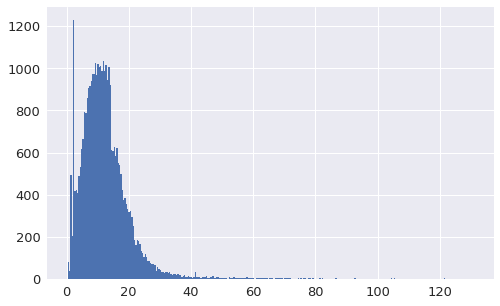

In [237]:
#Посмотрим на распределение целевого признака
sns.set(font_scale=1.3)
plt.figure(figsize=(8,5))
df['Ср. цена клика'].hist(bins=300);

In [238]:
# Посмотрим, что говорят статистические тесты.
print(stats.normaltest(df['Ср. цена клика']))
print('skew=',stats.skew(df['Ср. цена клика']))
print(stats.skewtest(df['Ср. цена клика']))


NormaltestResult(statistic=26615.136129223, pvalue=0.0)
skew= 3.289527474293754
SkewtestResult(statistic=131.7428446037317, pvalue=0.0)


***Вывод***: Благодаря статистическим тестам, ну это можно увидеть на графике, наши данные не распределены по нормальному распределению.  Также мы видим скошенность распределения.

Пропуски в данных мы изучили выше. При этом хочется заметить, что кроме пропусков в целвой переменной, пропусков в других данных не наблюдалось.

Теперь исследуем выбросы

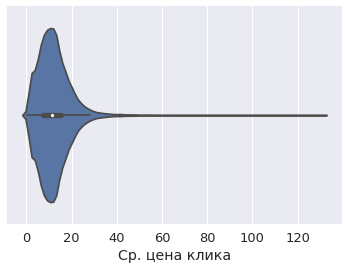

In [244]:
sns.violinplot(x='Ср. цена клика', scale='count',data=df);

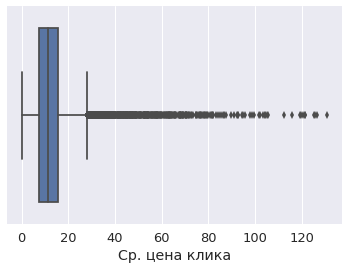

In [245]:
sns.boxplot( x='Ср. цена клика', data=df, orient="h");

**Вывод:** Видим, что в данных есть выборсы.
Единственно, посоветовавшись со специалистами было принято не убирать эти выбросы, тк группа выбросов, которая скучковалась около 120 являлась важным направлением для кампании. Те это были товары из одной категории.

# Часть 3. Первичный визуальный анализ признаков

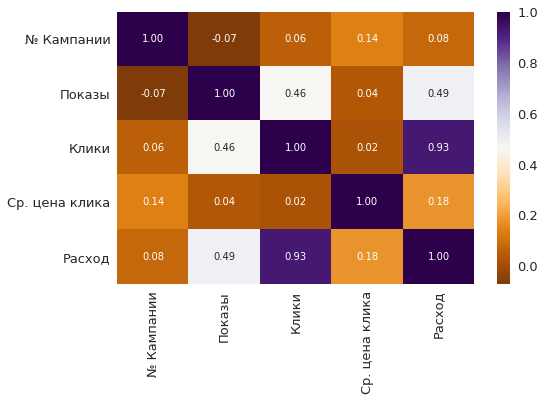

In [248]:
#Построим матрицу корреляции
plt.figure(figsize=(8,5))
corr_matrix=df.corr()
sns.heatmap(corr_matrix,annot=True,fmt = ".2f",cbar = True,cmap='PuOr',annot_kws={"size":10});

Матрица корреляции для непреобразованных признаков не очень информативна. Тк в нашем датасете в основном категориальные признаки и логичнее было строить эту матрицу корреляции не при первичном анализе данных, а уже после преобразования признаков.

Видим, что средняя цена наиболее коррелирует с расходами.
При этом с другими признаками корреляция очень мала. 

Единственно, что можно заметить, что у нас хорошо коррелируют признаки "Клики" и "Расходы", но это и логично.

<Figure size 864x576 with 0 Axes>

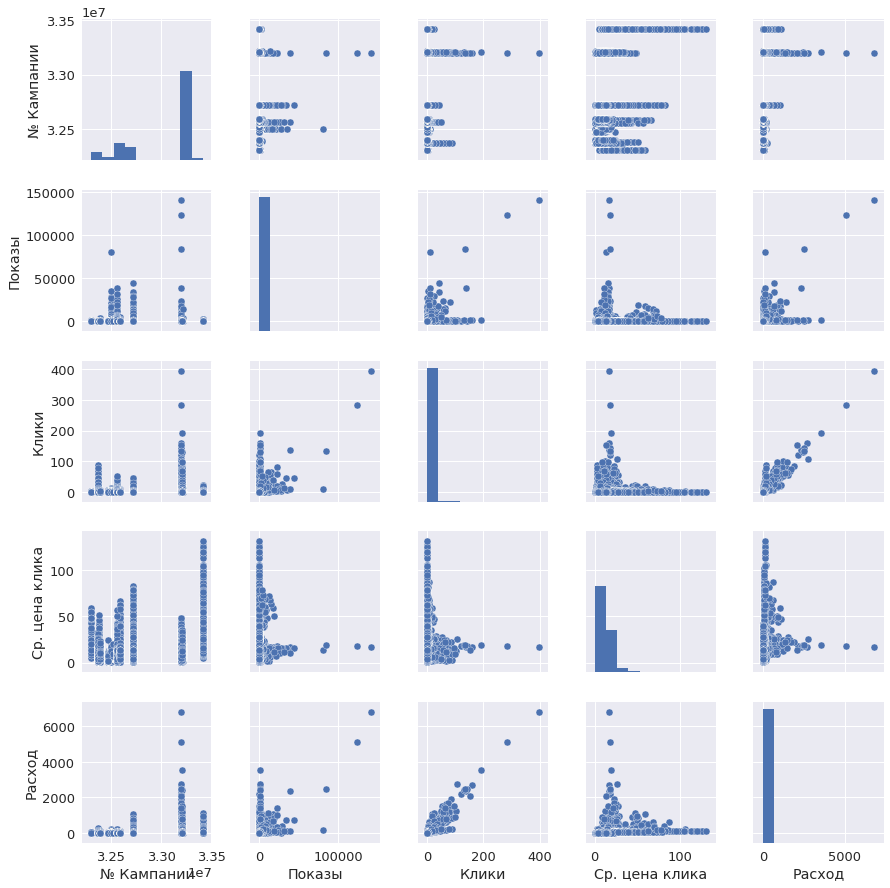

In [249]:
# Посмотрим на попарное распределение признаков
plt.figure(figsize=(12,8))
sns_plot = sns.pairplot(df);


Вприцнипе подтвердились все выводы, которые сделаны выше.

# Часть 4. Закономерности, "инсайты", особенности данных

Частично выводы были описаны выше, резюмируем здесь:

1) В силу того, что объявления создаются в автоматическом режиме, в бОльшинстве своем перебором различных параметров например перебираются различные комбинации параметров марки холодильника, станций метро где их можно купить и тд... Возникают слишком узкие запросы для объявления, например "купить по низкой цене Boshe-XC-003-87 в Марьино на улице Северянин". А такие узкие запросы практически не набираются пользователями. Следовательно у нас много строчек в датасете, где не только нет цлевой переменной, но и показов / кликов объявлений.

2) У нас видная небольша кучка данных около "средней цены" 120р - это оказалась определенная группа товаров у заказчика, причем важная группа товаров. Поэтому было приянто решение ее не очищать

3) Провели статистические тесты и поняли, что наша целевая переменная распределена не по нормальному закону и имееет скошенность.

4) Поняли, что матрица коррелиции, если не преобразовывать категориальные ризнаки,а запустить только на первычных признаках не несет никакой серьезной инормативности.

5) Также было замечено, что наш датасет основывается только на месяце марте. Если более внимательно изучить датасет, то можно заметить, что в основном он состоит из рекламных объявлений про подарки на 8марта. 
Изначально, кстати с заказчиком не оговаривалась такая особенность датасета, но это нам на руку в дальнейшем мы сможем выделить интересные признаки из этого.

6) Также удалим "Внешние сети" тк там одно значение для всех переменных.

# Часть 5. Выбор метрики

Так как мы решаем задачу регрессии, то можно использовать метрику MSE. Впринципе, можно было бы использовать и R2 метрику (коэффициент детерминации), но, вооружившись baseline в виде начального приближения средним, будем использовать MSE. 

Также самим заказчиком было предложено использовать метрику MSE, поэтому было принято оставить ее.

# Часть 6. Выбор модели

Для данной задачи случайный лес, не очень хорошо подойдет, так как в задаче приличное количество признаков категориального типа. Также мы будем использовать sparse формат, а в этом случаи хорошо заходят линейные модели. Может пригодиться и простая линейная регрессия.

Впрочем, ничто не мешает опробовать и другие регрессоры, что мы и сделаем далее.

Испробуем несколько моделей, после выберем наилучшую.


In [250]:
y = df['Ср. цена клика']
X = df.drop(['Ср. цена клика'], axis=1) 

In [251]:
#Разбиение выборки на train и test, первый 'baseline'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=True,random_state=42)

In [252]:
#Среднее значение оценки на трейне
y_mean=y_train.mean()
y_mean_for_test=[float(y_mean) for x in range(len(y_test))]
y_mean_for_train=[float(y_mean) for x in range(len(y_train))]

In [253]:
#Результаты приближения средним на трейне
print(mean_squared_error(y_train,y_mean_for_train))

69.80814037269853


In [254]:
#Результаты приближения средним на тесте.
#Получили baseline
baseline_mean=mean_squared_error(y_test,y_mean_for_test)
print(mean_squared_error(y_test,y_mean_for_test))

71.54670498647963


Мы создали для себя baseline, который будем стараться побить дальше.
Вaseline - приближение среднем всех значений.

# Часть 7. Предобработка данных

Так как в нашей задаче много категориальных признаков закодируем их OneHotEncoder.
Также есть признаки Расход, который является комбинацией целевого признака и признака "клики" - уберем его.
Также принято удалить признаки "Показы" и "Клики". Так как мы хотим предсказывать цену клика еще до показа объявлений, тк в нашем случаи на реальных данных этой колонки просто не будет.


PS Из самого df не будем удалять эти колонки, тк далее мы будем делать sparse матрицу, просто в нее не включим колонки выше, которые решили удалить.

In [ ]:
#Создадим новый признак CTR.
df['CTR'] = df['Клики']/df['Показы']

In [256]:
def OneHotEncoder_Me(df, colums):
    
    df_new = df.copy()
    
    le = LabelEncoder()
    df_new[colums] = le.fit_transform(df_new[colums])
        
    enc = OneHotEncoder(sparse=True)
    colums_enc = enc.fit_transform(df_new[colums].reshape(-1, 1))
    
    return colums_enc

In [257]:
type_adevrtising = OneHotEncoder_Me(df,'Тип объявления')
type_uslovie_pokaza = OneHotEncoder_Me(df,'Условие показа')
type_type_uslovie_pokaza = OneHotEncoder_Me(df,'Тип условия показа')
type_ploshadki = OneHotEncoder_Me(df,'Тип площадки')
type_region_targeting = OneHotEncoder_Me(df,'Регион таргетинга')
type_position = OneHotEncoder_Me(df,'Позиция')
type_device = OneHotEncoder_Me(df,'Тип устройства')




In [146]:
X = csr_matrix(hstack([type_adevrtising,
                       type_uslovie_pokaza, 
                       type_type_uslovie_pokaza,
                       type_ploshadki,
                       type_region_targeting,
                       type_position,
                       type_device
                    ]))

y = df['Ср. цена клика'].values

In [258]:
#Разобьем нашу выборку на Train и Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=True,random_state=42)

# Часть 8. Кросс-валидация и настройка гиперпараметров модели

In [165]:
#Приступим к выбору модели
#Список регрессоров
regressors = [LinearRegression(),
               RandomForestRegressor(random_state=42), 
               LinearSVR(random_state=42)]
regressor_name = ['LinearRegression',
                    'RandomForestRegressor', 
                    'LinearSVR']

In [169]:
#Параметры к регрессорам
scores = []
fits = []
linear_params = {'normalize': (True, False)}
forest_params = {'n_estimators': [100], 
                 'max_depth': list(range(3, 12, 4)), 
                 #'min_samples_leaf': list(range(10, 31, 10))
                }

svm_params = {'loss' : ('epsilon_insensitive', 'squared_epsilon_insensitive'), 'C': (0.1,0.25,0.5, 1, 2)}
params = [linear_params, forest_params, svm_params]

In [170]:
#Перебираем параметры регрессоров в поисках лучшего (на 5 фолдах)
np.random.seed(42)
for i, each_regressor in enumerate(regressors):
    reg = each_regressor
    reg_params = params[i]
    grid = GridSearchCV(reg, reg_params, 
                        cv=5,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1)
    grid.fit(X_train, y_train)
    fits.append(grid.best_params_)
    reg_best_score = grid.best_score_
    scores.append(reg_best_score)
    print(regressor_name[i], -reg_best_score, "\n", grid.best_params_, "\n")

LinearRegression 31.7588321129922 
 {'normalize': False} 

RandomForestRegressor 42.5449357017418 
 {'max_depth': 11, 'n_estimators': 100} 

LinearSVR 30.983540220587678 
 {'C': 0.5, 'loss': 'squared_epsilon_insensitive'} 



**Вывод:** Из моделей лучше всего сработал SVM.  Лучшие его параметры можно посмотреть выше.

# Часть 9. Создание новых признаков и описание этого процесса 

Создадим новые признаки: 

1) поработаем с датой (выделим, день, месяц и выходные)

2) создадим TF-IDF на признаке "условие показа" объявления

**Инсайт:** Также воспользуемся инсайтом, который заметили при первичном анализе данных. Напомню, что в нашем датасете все данные взяты только за март, соотвественно хорошим признаком будет выделить около празничные дни 8марта (те 7,8 марта)

In [171]:
df['DateTime'] = df['Дата'].apply(pd.to_datetime)

In [173]:
df['weekend'] =  df['DateTime'].apply(lambda x: 0 if x.weekday() < 5 else 1 )
df['marсh_7_8'] = df['DateTime'].apply(lambda x: 1 if x.day in[7,8] else 0 )

In [184]:
tfd=TfidfVectorizer(ngram_range=(1,2))

In [185]:
uslovie_pokaza_tfd=tfd.fit_transform(df['Условие показа'])

In [189]:
weekend = df['weekend'].reshape(-1,1)
marxh_7_8 = df['marсh_7_8'].reshape(-1,1)

/home/edvard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/home/edvard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [190]:
X = csr_matrix(hstack([type_adevrtising,
                       type_uslovie_pokaza, 
                       type_type_uslovie_pokaza,
                       type_ploshadki,
                       type_region_targeting,
                       type_position,
                       type_device,
                       uslovie_pokaza_tfd,
                       weekend,
                       marxh_7_8
                    ]))

y = df['Ср. цена клика'].values

In [259]:
# Снова разобьем на Train и Test , но уже с новыми призаками
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=True,random_state=42)

In [193]:
#Сделаем опять перебор по всем моедлям с теми же параметрами, но новыми признаками

np.random.seed(42)
for i, each_regressor in enumerate(regressors):
    reg = each_regressor
    reg_params = params[i]
    grid = GridSearchCV(reg, reg_params, 
                        cv=5,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1)
    grid.fit(X_train, y_train)
    fits.append(grid.best_params_)
    reg_best_score = grid.best_score_
    scores.append(reg_best_score)
    print(regressor_name[i], -reg_best_score, "\n", grid.best_params_, "\n")

LinearRegression 31.645950508913817 
 {'normalize': False} 

RandomForestRegressor 34.61495315752637 
 {'max_depth': 11, 'n_estimators': 100} 

LinearSVR 30.663856136977262 
 {'C': 0.25, 'loss': 'squared_epsilon_insensitive'} 



**Вывод:** Видим, что наши признаки улучшили метрику. 
Незначительно, но улучишили нашу метрику, причем на всех моделях.
Особенно улучшился RandomForest

Предыдущие значения:

LinearRegression 31.7588321129922 
 {'normalize': False} 

RandomForestRegressor 42.5449357017418 
 {'max_depth': 11, 'n_estimators': 100} 

LinearSVR 30.983540220587678 
 {'C': 0.5, 'loss': 'squared_epsilon_insensitive'} 

# Часть 10. Построение кривых валидации и обучения (4 балла)

In [198]:
#Лучше всего показал себя SVM 

svm = LinearSVR(C=0.5, loss='squared_epsilon_insensitive')


In [199]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(reg, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(reg,
                                                  X, y, train_sizes, cv=cv,
                                                  scoring=scoring)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

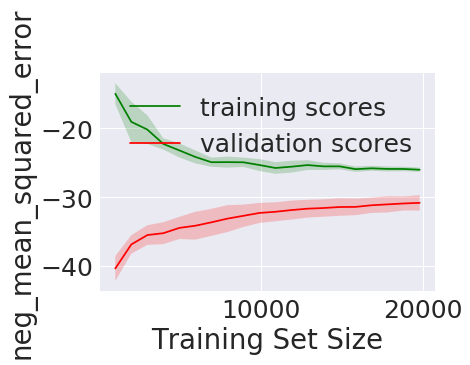

In [201]:
#Это график MSE со знаком минус, поэтому функции возрастают.
plot_learning_curve(svm,
                    X_train, y_train, scoring='neg_mean_squared_error', cv=5)

# Часть 11. Прогноз для тестовой или отложенной выборке

In [202]:
# Обучим нащшу модель
svm.fit(X_train, y_train)

LinearSVR(C=0.5, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=None, tol=0.0001, verbose=0)

In [204]:
predict = svm.predict(X_test)

In [205]:
mean_squared_error(y_test, predict)

32.47487036822144

In [208]:
print(mean_squared_error(y_test, predict),'vs baseline:',baseline_mean)

32.47487036822144 vs baseline: 71.54670498647963


 ### Вывод: ### 
 Результаты сравнимы с результатами на кроссвалидации.
 
 Также хочется заметить, что мы существенно обогнали baseline

# Часть 12. Выводы

Нам удалось существенно улучшить baseline благодаря добавлению новых признаков, а также использованию нескольких моделей, из которых мы потом выбрали наилучшую.

Изначально были предположения из-за сильно разряженного формата, что RandomForest не сработает, но при добавлении новых признаков и подборе гиперпараметров, он показал себе намного лучше, чем предполагалось.

Хотя самым лучшим оказался SVM.